<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#SGD" data-toc-modified-id="SGD-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>SGD</a></span></li><li><span><a href="#AdamW" data-toc-modified-id="AdamW-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>AdamW</a></span></li><li><span><a href="#SCG" data-toc-modified-id="SCG-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>SCG</a></span></li></ul></li><li><span><a href="#Demonstration-of-Training-Weights-for-Neural-Network-with-Single-Hidden-Layer" data-toc-modified-id="Demonstration-of-Training-Weights-for-Neural-Network-with-Single-Hidden-Layer-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demonstration of Training Weights for Neural Network with Single Hidden Layer</a></span></li></ul></div>

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

<font size="8">**Optimizers2**</font> 



In [2]:
%%writefile optimizers2.py

import numpy as np
import copy
import math
import sys  # for sys.float_info.epsilon

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights
        self.error_trace = []
        self.best_val_error = None
        self.best_epoch = None
        self.best_weights = None 

Writing optimizers2.py


## SGD
<a id='sgd'></a>

Now we define the first optimization algorithm, SGD.  We include the option of using [Nesterov accelerated gradient (NAG)](https://ruder.io/optimizing-gradient-descent/index.html#nesterovacceleratedgradient).  This link is a nice summary of many other optimizers, also.

In [3]:
%%writefile -a optimizers2.py

    def sgd(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, n_epochs=100, learning_rate=0.001, momentum=0, 
            weight_penalty=0,
            error_convert_f=None, error_convert_name='MSE', nesterov=False, verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
            Number of passes to take through all samples
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        momentum : float
            Controls amount of previous weight update to add to current weight update, only for sgd
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        nestoerov: momentum factor for Nesterov momentum. If False, then uses zero for no momentum
        verbose: if True print progress occasionally
        '''

        if self.error_trace == []:
            # not initialized yet
            self.prev_update = 0
            if nesterov:
                self.all_weights_copy = np.zeros(self.all_weights.shape)
 
        # learning_rate /= (Xtrain.shape[0] * Ttrain.shape[1])
        
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            # Assume to be standardized already
            error = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
            grad = gradient_f(Xtrain, Ttrain) + weight_penalty * self.all_weights

            val_error = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)

            if not nesterov:
                
                self.prev_update = learning_rate * grad + momentum * self.prev_update
                # Update all weights using -= to modify their values in-place.
                self.all_weights -= self.prev_update

            else:

                self.all_weights_copy[:] = self.all_weights 
                self.all_weights -= momentum * self.prev_update
                error = error_f(Xtrain, Ttrain)
                grad = gradient_f(Xtrain, Ttrain)
                self.prev_update = learning_rate * grad + momentum * self.prev_update
                self.all_weights[:] = self.all_weights_copy
                self.all_weights -= self.prev_update
                

            if error_convert_f:
                error = error_convert_f(error)
                val_error = error_convert_f(val_error)

            self.error_trace.append([error, val_error])

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'SGD: Epoch {epoch + 1} {error_convert_name}={error:.5f},{val_error:.5f}')

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()

        self.all_weights[:] = self.best_weights

        return self.error_trace

Appending to optimizers2.py


## AdamW
<a id='adamw'></a>

Now we add the basic [Adaptive Moment Estimation (Adam)](https://ruder.io/optimizing-gradient-descent/index.html#adam).  

In [4]:
%%writefile -a optimizers2.py

    ######################################################################
    #### adamw
    ######################################################################

    def adamw(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, n_epochs=100, learning_rate=0.001, weight_penalty=0,
              error_convert_f=None, error_convert_name='MSE', verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
            Number of passes to take through all samples
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        weight_penalty: if > 0, penalize large magnitude weights
        verbose: if True print progress occasionally
        '''

        if self.error_trace == []:
            shape = self.all_weights.shape
            # with multiple subsets (batches) of training data.
            self.mt = np.zeros(shape)
            self.vt = np.zeros(shape)
            self.sqrt = np.sqrt
                
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.beta1t = 1
            self.beta2t = 1

        # learning_rate /= (Xtrain.shape[0] * Ttrain.shape[1])

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
            grad = gradient_f(Xtrain, Ttrain) + weight_penalty * self.all_weights

            val_error = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= (alpha * m_hat / (self.sqrt(v_hat) + epsilon) + 
                                 weight_penalty * self.all_weights)
    
            if error_convert_f:
                error = error_convert_f(error)
                val_error = error_convert_f(val_error)

            self.error_trace.append([error, val_error])

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'AdamW: Epoch {epoch + 1} {error_convert_name}={error:.5f},{val_error:.5f}')

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()
                
        self.all_weights[:] = self.best_weights

        return self.error_trace

Appending to optimizers2.py


## SCG 
<a id='scg'></a>

And now the Scaled Conjugate Gradient, scg, algorithm.

In [5]:
%%writefile -a optimizers2.py

    ######################################################################
    #### scg
    ######################################################################

    def scg(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, n_epochs=100, weight_penalty=0,
            error_convert_f=None, error_convert_name='MSE', verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
            Number of passes to take through all samples
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        weight_penalty: if > 0, penalize large magnitude weights
        verbose: if True print progress occasionally
        '''

        if self.error_trace == []:
            shape = self.all_weights.shape
            self.w_new = np.zeros(shape)
            self.w_temp = np.zeros(shape)
            self.g_new = np.zeros(shape)
            self.g_old = np.zeros(shape)
            self.g_smallstep = np.zeros(shape)
            self.search_dir = np.zeros(shape)

        sigma0 = 1.0e-6
        val_fold = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)
        fold = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
        error = fold
        val_error = val_fold
        self.g_new[:] = gradient_f(Xtrain, Ttrain) + weight_penalty * self.all_weights
        self.g_old[:] = copy.deepcopy(self.g_new)
        self.search_dir[:] = -self.g_new
        success = True				# Force calculation of directional derivs.
        nsuccess = 0				# nsuccess counts number of successes.
        beta = 1.0e-6				# Initial scale parameter. Lambda in Moeller.
        betamin = 1.0e-15 			# Lower bound on scale.
        betamax = 1.0e20			# Upper bound on scale.
        nvars = len(self.all_weights)
        epoch = 1				# j counts number of epochs

        # Main optimization loop.
        while epoch <= n_epochs:

            # Calculate first and second directional derivatives.
            if success:
                mu = self.search_dir @ self.g_new
                if mu >= 0:
                    self.search_dir[:] = - self.g_new
                    mu = self.search_dir.T @ self.g_new
                kappa = self.search_dir.T @ self.search_dir
                if math.isnan(kappa):
                    print('kappa', kappa)

                if kappa < sys.float_info.epsilon:
                    return self.error_trace

                sigma = sigma0 / math.sqrt(kappa)

                self.w_temp[:] = self.all_weights
                self.all_weights += sigma * self.search_dir
                error_f(Xtrain, Ttrain)  #  + weight_penalty * np.sum(self.all_weights ** 2)
                self.g_smallstep[:] = gradient_f(Xtrain, Ttrain) + weight_penalty * self.all_weights
                self.all_weights[:] = self.w_temp

                theta = self.search_dir @ (self.g_smallstep - self.g_new) / sigma
                if math.isnan(theta):
                    print('theta', theta, 'sigma', sigma, 'search_dir[0]', self.search_dir[0], 'g_smallstep[0]', self.g_smallstep[0])

            ## Increase effective curvature and evaluate step size alpha.

            delta = theta + beta * kappa
            # if math.isnan(scalarv(delta)):
            if math.isnan(delta):
                print('delta is NaN', 'theta', theta, 'beta', beta, 'kappa', kappa)
            elif delta <= 0:
                delta = beta * kappa
                beta = beta - theta / kappa

            if delta == 0:
                success = False
                fnow = fold
                val_fnow = val_fold
            else:
                alpha = -mu / delta
                ## Calculate the comparison ratio Delta
                self.w_temp[:] = self.all_weights
                self.all_weights += alpha * self.search_dir
                val_fnew = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)
                fnew = error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
                Delta = 2 * (fnew - fold) / (alpha * mu)
                if not math.isnan(Delta) and Delta  >= 0:
                    success = True
                    nsuccess += 1
                    fnow = fnew
                    val_fnow = val_fnew
                else:
                    success = False
                    fnow = fold
                    val_fnow = val_fold
                    self.all_weights[:] = self.w_temp

            epochsPerPrint = math.ceil(n_epochs/10)
            if verbose and epoch % max(1, epochsPerPrint) == 0:
                print(f'SCG: Epoch {epoch} {error_convert_name}={error:.5f},{val_error:.5f}')

            if error_convert_f:
                val_error = error_convert_f(val_fnow)
                error = error_convert_f(fnow)
            else:
                error = fnow
                val_error = val_fnow
            self.error_trace.append([error, val_error])

            if success:

                fold = fnew
                val_fold = val_fnew
                self.g_old[:] = self.g_new
                self.g_new[:] = gradient_f(Xtrain, Ttrain) + weight_penalty * self.all_weights

                # If the gradient is zero then we are done.
                gg = self.g_new @ self.g_new  # dot(gradnew, gradnew)
                if gg == 0:
                    return self.error_trace

            if math.isnan(Delta) or Delta < 0.25:
                beta = min(4.0 * beta, betamax)
            elif Delta > 0.75:
                beta = max(0.5 * beta, betamin)

            # Update search direction using Polak-Ribiere formula, or re-start
            # in direction of negative gradient after nparams steps.
            if nsuccess == nvars:
                self.search_dir[:] = -self.g_new
                nsuccess = 0
            elif success:
                gamma = (self.g_old - self.g_new) @ (self.g_new / mu)
                #self.search_dir[:] = gamma * self.search_dir - self.g_new
                self.search_dir *= gamma
                self.search_dir -= self.g_new

            epoch += 1

            # If we get here, then we haven't terminated in the given number of
            # epochs.

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()

        self.all_weights[:] = self.best_weights

        return self.error_trace

Appending to optimizers2.py


# Demonstration of Training Weights for Neural Network with Single Hidden Layer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers2 as opt

In [2]:
######################################################################
# Make date and partition randomly into training, validation, and testing

Xtrain = np.arange(-2, 2, 0.05).reshape(-1, 1)
Ttrain = np.sin(Xtrain) * np.sin(Xtrain * 5)
    
Xval = Xtrain * 1.1  # + 0.2
Tval = Ttrain + 0.2 * Xtrain
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain # + np.random.uniform(-0.05, 0.05, Ttrain.shape) 
        
n_samples, n_inputs = Xtrain.shape
n_outputs = Ttrain.shape[1]

In [98]:
X = np.arange(0, 2, 0.5).reshape(-1, 1)
T = np.sin(X) * np.sin(X * 10)
n_samples, n_inputs = X.shape
n_outputs = 1

X,T

(array([[0. ],
        [0.5],
        [1. ],
        [1.5]]),
 array([[ 0.        ],
        [-0.45973279],
        [-0.45777798],
        [ 0.64865886]]))

In [4]:
Ttrain.shape

(80, 1)

In [99]:
######################################################################
# Make weight and gradient one-dimensional vectors and matrix views
# Neural net has only one hidden layer.
# first Layer

n_hiddens_1 = 2
n_hiddens_2 = 2

# Weight vector and matrix views
    
V0shape = (1 + n_inputs, n_hiddens_1)
V1shape = (1+n_hiddens_1, n_hiddens_2)
Wshape = (1 + n_hiddens_2, n_outputs)

n_V0 = np.prod(V0shape)
n_V1 = np.prod(V1shape)
n_W = np.prod(Wshape)
n_weights = n_V0 +n_V1 + n_W
all_weights = np.random.uniform(-1, 1, n_weights)
V0 = all_weights[:n_V0].reshape(V0shape)
V0 /= np.sqrt(V0shape[0])
V1 = all_weights[n_V0:n_V1+n_V0].reshape(V1shape)
V1 /= np.sqrt(V1shape[0])
W = all_weights[n_V1+n_V0:].reshape(Wshape)
W /= np.sqrt(Wshape[0])
Ws = [V0, V1, W]

# Gradient vector and matrix views

all_gradients = np.zeros_like(all_weights)
grad_V0 = all_gradients[:n_V0].reshape(V0shape)
grad_V1 = all_gradients[n_V0:n_V1+n_V0].reshape(V1shape)
grad_W = all_gradients[n_V1+n_V0:].reshape(Wshape) 

grads = [grad_V0, grad_V1, grad_W]

In [100]:
all_weights.shape

(13,)

In [35]:
V0.shape, V1.shape, W.shape

((2, 2), (3, 2), (3, 1))

In [47]:
V0shape, V1shape, Wshape

((2, 2), (3, 2), (3, 1))

In [37]:
all_gradients.shape

(13,)

In [48]:
all_weights.shape

(13,)

In [39]:
grad_W.shape

(3, 1)

In [119]:
######################################################################
# Neural network functions
    
def rmse_unstandardized(T, Y, Tstds):
    return np.sqrt(np.mean((T - Y)**2, axis=0))[0]

def add_ones(A):
    return np.insert(A, 0, 1, axis=1)

# Function to be minimized by optimizer method, mean squared error
def error_f(X, T):
    global Zs, Z0, Z1, Y
    # forward pass
    Z0 = np.tanh(add_ones(X) @ V0)
    Z1 = np.tanh(add_ones(Z0) @ V1)
    Y = add_ones(Z1) @ W
    mean_sq_error = np.mean((T - Y) ** 2)
    
    Zs = [X,Z0, Z1, Y]     
    print(Z0, Z1, Y)
#     for i in range(len(self.Ws) -1):
#         z = np.tanh(add_ones(self.Zs[i]) @ self.Ws[i])
#         self.Zs.append(z)

#     Y = add_ones(Zs[-1]) @ Ws[-1]
#     Zs.append(Y)
    return mean_sq_error

# Gradient of function to be minimized for use by optimizer method
def gradient_f(X, T):
    global Zs, Z0, Z1, Y, grad_W, grad_V0, grad_V1, all_gradients   # remove ones that aren't changed in this function
    n_samples = X.shape[0]
    n_outputs = T.shape[1]
    Dw = -(T - Y) / (n_samples * n_outputs)
    grad_W[:] = add_ones(Z1).T @ Dw
    
    Dv1 = Dw @ W[1:, :].T * (1 - Z1**2)
    grad_V1[:] = add_ones(Z0).T @ Dv1

    Dv0 = Dv1 @ V1[1:, :].T * (1 - Z0**2)
    grad_V0[:] = add_ones(X).T @ Dv0

    return all_gradients

# Apply network to data X
def use(X):
    X = (X - Xmeans) / Xstds
    Z = np.tanh(add_ones(X) @ V0)
    Z = np.tanh(add_ones(Z) @ V1)
    Y = add_ones(Z) @ W
    return Y * Tstds + Tmeans

In [102]:
Xtrain = X
Ttrain = T
Xval = X
Tval = T

In [103]:
######################################################################
# Standardize data
    
Xmeans = Xtrain.mean(axis=0)
Xstds = Xtrain.std(axis=0)
Tmeans = Ttrain.mean(axis=0)
Tstds = Ttrain.std(axis=0)

XtrainS = (Xtrain - Xmeans) / Xstds
TtrainS = (Ttrain - Tmeans) / Tstds
XvalS = (Xval - Xmeans) / Xstds
TvalS = (Tval - Tmeans) / Tstds
# XtestS = (Xtest - Xmeans) / Xstds
# TtestS = (Ttest - Tmeans) / Tstds

In [120]:
all_weights[:] = np.arange(len(all_weights)) * 0.001

In [105]:
all_weights, Ws

(array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012]),
 [array([[0.   , 0.001],
         [0.002, 0.003]]),
  array([[0.004, 0.005],
         [0.006, 0.007],
         [0.008, 0.009]]),
  array([[0.01 ],
         [0.011],
         [0.012]])])

In [121]:
######################################################################
# Ready to train!
    
optimizer = opt.Optimizers(all_weights)
    
method = 'sgd'

if method == 'sgd':
      
    n_epochs = 1
    learning_rate = 0.1
    momentum = 0.
    weight_penalty = 0
    error_trace = optimizer.sgd(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                                n_epochs=n_epochs, learning_rate=learning_rate,
                                momentum=momentum, weight_penalty=weight_penalty,
                                verbose=True)
        
elif method == 'adamw':

    n_epochs = 10000
    learning_rate = 0.005
    weight_penalty = 0
    error_trace = optimizer.adamw(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                                  n_epochs=n_epochs, learning_rate=learning_rate,
                                  weight_penalty=weight_penalty,
                                  verbose=True)

elif method == 'scg':

    n_epochs = 2000
    weight_penalty = 0.0
    error_trace = optimizer.scg(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                                n_epochs=n_epochs, 
                                weight_penalty=weight_penalty,
                                verbose=True) 
    
else:
    print('method must be \'sgd\', \'adamw\' or \'scg\' ')

[[-0.00268328 -0.00302491]
 [-0.00089443 -0.00034164]
 [ 0.00089443  0.00234164]
 [ 0.00268328  0.00502488]] [[0.00395968 0.00495395]
 [0.00399188 0.00499062]
 [0.00402408 0.00502729]
 [0.00405628 0.00506396]] [[0.010103  ]
 [0.0101038 ]
 [0.01010459]
 [0.01010539]]
[[-0.00268328 -0.00302491]
 [-0.00089443 -0.00034164]
 [ 0.00089443  0.00234164]
 [ 0.00268328  0.00502488]] [[0.00395968 0.00495395]
 [0.00399188 0.00499062]
 [0.00402408 0.00502729]
 [0.00405628 0.00506396]] [[0.010103  ]
 [0.0101038 ]
 [0.01010459]
 [0.01010539]]
SGD: Epoch 1 MSE=1.00010,1.00010


In [118]:
Z0, Z1, Y

(array([[-0.00269309, -0.00303773],
        [-0.0008978 , -0.00034605],
        [ 0.00089749,  0.00234565],
        [ 0.00269278,  0.0050373 ]]),
 array([[0.0039484 , 0.00494164],
        [0.00398071, 0.00497843],
        [0.00401302, 0.00501523],
        [0.00404533, 0.00505203]]),
 array([[0.00909229],
        [0.00909308],
        [0.00909388],
        [0.00909468]]))

In [110]:
np.tanh(add_ones(X) @ V0)

array([[0.        , 0.001     ],
       [0.001     , 0.00249999],
       [0.002     , 0.00399998],
       [0.00299999, 0.00549994]])

In [111]:
Zs

[array([[-1.34164079],
        [-0.4472136 ],
        [ 0.4472136 ],
        [ 1.34164079]]),
 array([[-0.00268328, -0.00302491],
        [-0.00089443, -0.00034164],
        [ 0.00089443,  0.00234164],
        [ 0.00268328,  0.00502488]]),
 array([[0.00395968, 0.00495395],
        [0.00399188, 0.00499062],
        [0.00402408, 0.00502729],
        [0.00405628, 0.00506396]]),
 array([[0.010103  ],
        [0.0101038 ],
        [0.01010459],
        [0.01010539]])]

In [81]:
grad_V0, grad_V1, grad_W

(array([[ 1.51603124e-06,  1.98217653e-06],
        [-7.19909102e-05, -9.40663907e-05]]),
 array([[ 1.11145896e-04,  1.21249680e-04],
        [-1.05587719e-05, -1.15185542e-05],
        [-1.57268813e-05, -1.71564392e-05]]),
 array([[1.01041953e-02],
        [2.32194989e-05],
        [3.09340617e-05]]))

In [79]:
grads

[array([[ 1.51603124e-06,  1.98217653e-06],
        [-7.19909102e-05, -9.40663907e-05]]),
 array([[ 1.11145896e-04,  1.21249680e-04],
        [-1.05587719e-05, -1.15185542e-05],
        [-1.57268813e-05, -1.71564392e-05]]),
 array([[1.01041953e-02],
        [2.32194989e-05],
        [3.09340617e-05]])]

In [93]:
V0, V1, W

(array([[-1.51603124e-07,  9.99801782e-04],
        [ 2.00719909e-03,  3.00940664e-03]]),
 array([[0.00398889, 0.00498788],
        [0.00600106, 0.00700115],
        [0.00800157, 0.00900172]]),
 array([[0.00898958],
        [0.01099768],
        [0.01199691]]))

In [96]:
add_ones(Z1) @ W

array([[0.00909256],
       [0.00909335],
       [0.00909415],
       [0.00909494]])

In [97]:
T

array([[ 0.        ],
       [-0.45973279],
       [-0.45777798],
       [ 0.64865886]])

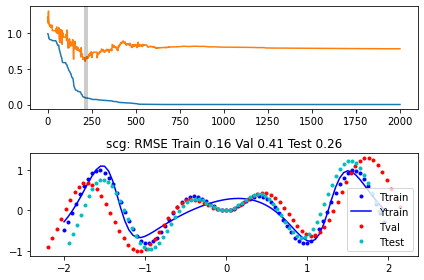

In [14]:
plt.subplot(2, 1, 1)
plt.plot(error_trace)
plt.axvline(optimizer.best_epoch, ymin=0, ymax=1, color='black', lw=4, alpha=0.2)

plt.subplot(2, 1, 2)
plt.plot(Xtrain, Ttrain, 'b.', label='Ttrain')
plt.plot(Xtrain, use(Xtrain), 'b-', label='Ytrain')

plt.plot(Xval, Tval, 'r.', label='Tval')
plt.plot(Xtest, Ttest, 'c.', label='Ttest')
plt.legend()

title = f'{method}: RMSE Train {rmse_unstandardized(Ttrain, use(Xtrain), Tstds):.2f}'
title += f' Val {rmse_unstandardized(Tval, use(Xval), Tstds):.2f}'
title += f' Test {rmse_unstandardized(Ttest, use(Xtest), Tstds):.2f}'
plt.title(title)
plt.tight_layout();